<a href="https://colab.research.google.com/github/bri-thetechie/cnn-waste-sorter/blob/main/training%26eva_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
# import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight


# ----------------------
# Reproducibility Settings
# ----------------------
# seed_value = 42
# os.environ["PYTHONHASHSEED"] = str(seed_value)
# random.seed(seed_value)
# np.random.seed(seed_value)
# tf.random.set_seed(seed_value)

# For reproducibility in CuDNN (slows down training a bit)
# os.environ["TF_DETERMINISTIC_OPS"] = "1"

# ----------------------
# Paths
# ----------------------
base_dir = "/content/drive/MyDrive/NNDL_final"   # balanced dataset

img_size = (128,128)
batch_size = 16

# ----------------------
# Custom Preprocessing Function (Brightness Fix)
# ----------------------
def preprocess_img(img):
    img = img.astype(np.uint8)

    # Convert to HSV and equalize brightness channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return img.astype(np.float32)

# ----------------------
# Image Data Generator with Augmentation
# ----------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    preprocessing_function=preprocess_img
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# ----------------------
# CNN Model (EDA + refinements)
# ----------------------



model = Sequential([
    # Block 1
    Conv2D(36, (3,3), activation="relu", padding="same", input_shape=(128,128,3)),
    MaxPooling2D((2,2)),

    # Block 2 (extra depth for textures)
    Conv2D(64, (3,3), activation="relu", padding="same"),
    MaxPooling2D((2,2)),

    # Dense
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")  # 3 classes
])

# ----------------------
# Compile
# ----------------------
model.compile(
    optimizer= "adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ----------------------
# Class Weights (slightly upweight Wet waste for recall)
# ----------------------
class_weights = class_weight.compute_class_weight(
    "balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
# Assuming class order = {0: Dry, 1: E-Waste, 2: Wet}
class_weights[2] *= 1.2
print("Adjusted Class Weights:", class_weights)

# ----------------------
# Callbacks
# ----------------------
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ----------------------
# Train
# ----------------------
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# ----------------------
# Save model
# ----------------------
model.save("/content/drive/MyDrive/NNDL_final/model_1.h5")


Found 480 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Adjusted Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.2)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.3940 - loss: 1.3688 - val_accuracy: 0.5000 - val_loss: 1.0563 - learning_rate: 0.0010
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5536 - loss: 1.0432 - val_accuracy: 0.4917 - val_loss: 1.0258 - learning_rate: 0.0010
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6047 - loss: 0.9195 - val_accuracy: 0.6417 - val_loss: 0.8262 - learning_rate: 0.0010
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6398 - loss: 0.8531 - val_accuracy: 0.6083 - val_loss: 0.8514 - learning_rate: 0.0010
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6282 - loss: 0.8558 - val_accuracy: 0.6667 - val_loss: 0.8050 - learning_rate: 0.0010
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7192 - loss: 0.7850 - val_accuracy: 0.6417 - val_loss: 0.7672 - learning_rate: 0.0010
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7242 - loss: 0.7228 - val_accuracy:

In [2]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 36)   │         1,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,232,795 (96.26 MB)

 Trainable params: 8,410,931 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,821,864 (64.17 MB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.5925 - loss: 0.8665

Validation Accuracy: 0.6667
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step


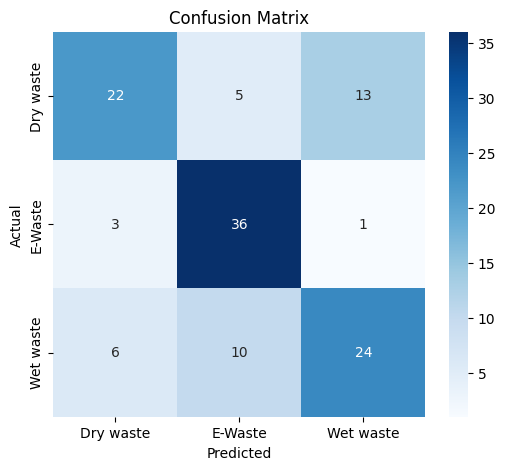


Classification Report:
              precision    recall  f1-score   support

   Dry waste       0.71      0.55      0.62        40
     E-Waste       0.71      0.90      0.79        40
   Wet waste       0.63      0.60      0.62        40

    accuracy                           0.68       120
   macro avg       0.68      0.68      0.68       120
weighted avg       0.68      0.68      0.68       120



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Image: /content/drive/MyDrive/NNDL/test1_dry.jpg → Predicted: Dry waste (Confidence: 0.90)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Image: /content/drive/MyDrive/NNDL/test2_e-w.jpg → Predicted: E-Waste (Confidence: 0.99)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image: /content/drive/MyDrive/NNDL/test3_wet.jpg → Predicted: Wet waste (Confidence: 0.97)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# ===============================
# 1. Model Evaluation
# ===============================

# ----------------------
# Evaluation
# ----------------------
val_loss, val_acc = model.evaluate(val_generator)
print(f"\nValidation Accuracy: {val_acc:.4f}")

# ----------------------
# Classification Report & Confusion Matrix
# ----------------------
val_labels = val_generator.classes
class_indices = val_generator.class_indices
idx_to_class = {v:k for k,v in class_indices.items()}
class_labels = list(val_generator.class_indices.keys())

# Predictions
val_preds = model.predict(val_generator, verbose=1)
val_pred_classes = np.argmax(val_preds, axis=1)

# Confusion Matrix
cm = confusion_matrix(val_labels, val_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(class_indices.keys()),
            yticklabels=list(class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, val_pred_classes, target_names=list(class_indices.keys())))

# ===============================
# 2. Deployment – Load Model & Predict New Images
# ===============================
# Load saved model (to simulate deployment)
deployed_model = load_model("/content/drive/MyDrive/NNDL_final/model_1.h5")

def predict_image(img_path, model, class_labels):
    img = image.load_img(img_path, target_size=(128,128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # batch dimension
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)
    return predicted_class, confidence

# Example: predict 3 custom images
test_images = [
    "/content/drive/MyDrive/NNDL/test1_dry.jpg",
    "/content/drive/MyDrive/NNDL/test2_e-w.jpg",
    "/content/drive/MyDrive/NNDL/test3_wet.jpg"
]

for img_path in test_images:
    pred_class, conf = predict_image(img_path, deployed_model, class_labels)
    print(f"Image: {img_path} → Predicted: {pred_class} (Confidence: {conf:.2f})")
